# Convolutional Neural Network IMBD

Proyecto para Interpretación de sentimientos con Lenguaje Natural

## Librerias

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk import ngrams as nltk_ngrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
english_words = set(words.words())
import re
import string

lemmatizer = WordNetLemmatizer()

from collections import Counter


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maico\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maico\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\maico\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Limpieza y preparación de Datos

In [7]:
df = pd.read_csv("./Data/IMDB Dataset.csv")
df.head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


In [9]:
#Convertir sentimiento a bolean
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [10]:
#Proceso de limpieza de texto
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()

    # Eliminar etiquetas HTML
    text = re.sub(r'<.*?>', '', text)

    # Eliminar nombres propios
    text = re.sub(r'\b[A-Z][a-z]+(?:\'[a-z]+)?\b', '', text)

    # Eliminar frases entre comillas dobles
    text = re.sub(r'\".*?\"', '', text)

    # Eliminar contenido entre corchetes
    text = re.sub(r'\[.*?\]', '', text)

    # Eliminar puntuación
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)

    # Eliminar palabras con números
    text = re.sub(r'\w*\d\w*', '', text)

    # Eliminar caracteres repetidos
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Eliminar números
    text = re.sub(r'\d+', '', text)

    # Eliminar palabras muy largas o muy cortas
    text = ' '.join([word for word in text.split() if 2 <= len(word) <= 16])

    # Eliminar stopwords, conservando palabras específicas
    stop_words = set(stopwords.words('english'))
    keep_words = {'what', 'who', 'why', 'when', 'where', 'how'}  # Palabras importantes
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words or word in keep_words])

    # Filtrar palabras que contengan solo letras
    text = ' '.join([word for word in text.split() if word.isalpha()])

    # Filtrar palabras con prefijos anómalos
    text = ' '.join([word for word in text.split() if not word.startswith('aa')])
    # Lematización
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text


In [11]:
df_preprocessed = df.copy()

In [12]:
df_preprocessed['review'] = df_preprocessed['review'].apply(preprocess_text)

In [13]:
df_preprocessed.head(2)

,review,sentiment
0,one reviewer mentioned watching oz episode you...,1
1,wonderful little production filming technique ...,1


## EDA

### Generar bigramas

Creamos bigramas para hacer relación más rapidamente de las combinaciónes que definen un comentario positivo y negativo

In [13]:
 # Import ngrams and give it a unique name


In [ ]:
def generate_ngrams(text, n):
    tokens = text.lower().split()
    n_grams = list(nltk_ngrams(tokens, n))  # Use the imported function
    return n_grams

n = 2  # You can change this to generate different n-grams (e.g., 3 for trigrams)
df_preprocessed['ngrams'] = df_preprocessed['review'].apply(lambda x: generate_ngrams(x, n))

# Separate ngrams by sentiment
positive_ngrams = [ngram for sentiment, ngrams_list in zip(df_preprocessed['sentiment'], df_preprocessed['ngrams'])
                   if sentiment == 1 for ngram in ngrams_list]
negative_ngrams = [ngram for sentiment, ngrams_list in zip(df_preprocessed['sentiment'], df_preprocessed['ngrams'])
                   if sentiment == 0 for ngram in ngrams_list]

In [14]:
df_preprocessed.head()

,review,sentiment
0,one reviewer mentioned watching oz episode you...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically there family where little boy jake t...,0
4,petter matteis visually stunning film watch mr...,1


contar frecuencias

In [16]:
positive_ngram_counts = Counter(positive_ngrams)
negative_ngram_counts = Counter(negative_ngrams)


#### Calcular diferencia de frecuencias

Ayuda a evitar tener en cuenta ngramas que se repitan tanto en comentarios positivos como en negativos, los cuales no terminan siendo de mucha ayuda

In [17]:
'''
all_words = set(negative_ngram_counts.keys()).union(set(positive_ngram_counts.keys()))

# Crear un diccionario para las diferencias de frecuencias
frequency_differences = {}

for word in all_words:
    # Obtén la frecuencia de cada palabra en ambas listas, si no existe, asigna 0
    negative_freq = negative_ngram_counts.get(word, 0)
    positive_freq = positive_ngram_counts.get(word, 0)

    # Restar la frecuencia de las palabras
    frequency_differences[word] =  positive_freq - negative_freq

# Ordenar las palabras por la diferencia de frecuencias (de mayor a menor)
sorted_frequency_differences = sorted(frequency_differences.items(), key=lambda x: x[1], reverse=True)
'''

'\nall_words = set(negative_ngram_counts.keys()).union(set(positive_ngram_counts.keys()))\n\n# Crear un diccionario para las diferencias de frecuencias\nfrequency_differences = {}\n\nfor word in all_words:\n    # Obtén la frecuencia de cada palabra en ambas listas, si no existe, asigna 0\n    negative_freq = negative_ngram_counts.get(word, 0)\n    positive_freq = positive_ngram_counts.get(word, 0)\n\n    # Restar la frecuencia de las palabras\n    frequency_differences[word] =  positive_freq - negative_freq\n\n# Ordenar las palabras por la diferencia de frecuencias (de mayor a menor)\nsorted_frequency_differences = sorted(frequency_differences.items(), key=lambda x: x[1], reverse=True)\n'

### Análisis de bigramas

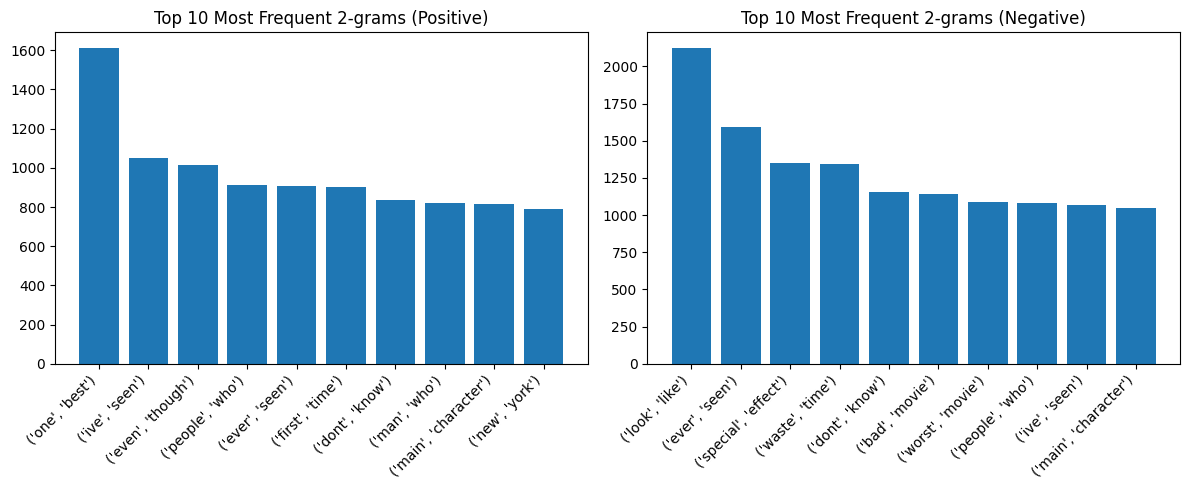

In [18]:
# graficar los mejores 10 ngramas por categoria
top_n = 10

top_positive_ngrams = positive_ngram_counts.most_common(top_n)
top_negative_ngrams = negative_ngram_counts.most_common(top_n)

#Prepare data for plotting
ngrams_pos = [str(ngram) for ngram, count in top_positive_ngrams]
counts_pos = [count for ngram, count in top_positive_ngrams]

ngrams_neg = [str(ngram) for ngram, count in top_negative_ngrams]
counts_neg = [count for ngram, count in top_negative_ngrams]



plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(ngrams_pos, counts_pos)
plt.title(f'Top {top_n} Most Frequent {n}-grams (Positive)')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.bar(ngrams_neg, counts_neg)
plt.title(f'Top {top_n} Most Frequent {n}-grams (Negative)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Análisis por categorias

In [19]:
positive_reviews = df_preprocessed[df_preprocessed['sentiment'] == 1]['review']
negative_reviews = df_preprocessed[df_preprocessed['sentiment'] == 0]['review']

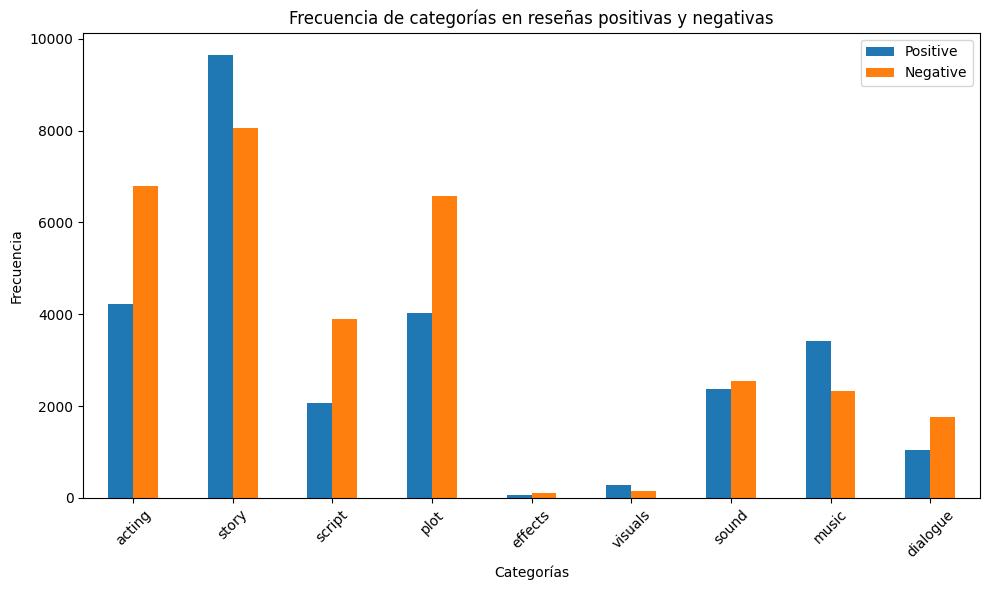

In [20]:
# Categorías clave a analizar
categories = ['acting', 'story', 'script', 'plot', 'effects', 'visuals', 'sound', 'music', 'dialogue']

# Función para buscar frecuencia de las categorías
def category_analysis(reviews, categories):
    frequencies = {}
    examples = {}
    for category in categories:
        frequencies[category] = reviews.str.contains(category, case=False, na=False).sum()
    return frequencies

# reseñas positivas
positive_freq = category_analysis(positive_reviews, categories)

# reseñas negativas
negative_freq = category_analysis(negative_reviews, categories)

# Crear un DataFrame para frecuencias
freq_df = pd.DataFrame({'Positive': positive_freq, 'Negative': negative_freq})

# Gráfico de frecuencias
freq_df.plot(kind='bar', figsize=(10, 6))
plt.title('Frecuencia de categorías en reseñas positivas y negativas')
plt.ylabel('Frecuencia')
plt.xlabel('Categorías')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
'''import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from textblob import TextBlob
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Descargar recursos necesarios
nltk.download('punkt')
nltk.download('punkt_tab')

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')'''

"import nltk\nfrom nltk.tokenize import word_tokenize\nfrom nltk import pos_tag\nfrom nltk.corpus import stopwords\nfrom textblob import TextBlob\nimport matplotlib.pyplot as plt\nfrom scipy.stats import ttest_ind\n\n# Descargar recursos necesarios\nnltk.download('punkt')\nnltk.download('punkt_tab')\n\nnltk.download('averaged_perceptron_tagger')\nnltk.download('stopwords')\nnltk.download('averaged_perceptron_tagger_eng')"

In [22]:
'''
# Asume que el DataFrame tiene columnas: 'review' (texto) y 'sentiment' (positivo/negativo)
# Carga los datos
df = df_preprocessed.copy()  # Carga tus datos aquí

# Función para preprocesar y etiquetar partes del discurso
def pos_analysis(text):
    tokens = word_tokenize(text.lower())
    tags = pos_tag(tokens)
    return tags

# Función para contar categorías gramaticales
def count_pos_tags(pos_tags):
    counts = {"adjective": 0, "noun": 0, "verb": 0}
    for word, tag in pos_tags:
        if tag.startswith('JJ'):
            counts['adjective'] += 1
        elif tag.startswith('NN'):
            counts['noun'] += 1
        elif tag.startswith('VB'):
            counts['verb'] += 1
    return counts

# Aplicar el análisis POS y calcular emociones
pos_counts = {"positive": [], "negative": []}
emotion_scores = {"positive": [], "negative": []}

for _, row in df.iterrows():
    sentiment = row['sentiment']  # sentiment is 1 or 0
    review = row['review']
    pos_tags = pos_analysis(review)
    pos_count = count_pos_tags(pos_tags)

    # Convert sentiment to the corresponding key
    sentiment_key = "positive" if sentiment == 1 else "negative"

    # Guardar conteos de partes del discurso using sentiment_key
    pos_counts[sentiment_key].append(pos_count)

    # Analizar emociones
    polarity = TextBlob(review).sentiment.polarity
    emotion_scores[sentiment_key].append(polarity)

# Agregar análisis estadístico
def average_counts(counts_list):
    return {
        "adjective": sum(c['adjective'] for c in counts_list) / len(counts_list),
        "noun": sum(c['noun'] for c in counts_list) / len(counts_list),
        "verb": sum(c['verb'] for c in counts_list) / len(counts_list),
    }

positive_counts_avg = average_counts(pos_counts["positive"])
negative_counts_avg = average_counts(pos_counts["negative"])

# Comparar estadísticamente los resultados
positive_polarity = emotion_scores["positive"]
negative_polarity = emotion_scores["negative"]

# Prueba T para cada categoría gramatical
for category in ["adjective", "noun", "verb"]:
    positive_data = [c[category] for c in pos_counts["positive"]]
    negative_data = [c[category] for c in pos_counts["negative"]]
    stat, p_value = ttest_ind(positive_data, negative_data)
    print(f"{category.capitalize()} - T-test p-value: {p_value}")

# Comparación de emociones
stat, p_value = ttest_ind(positive_polarity, negative_polarity)
print(f"Emotion polarity - T-test p-value: {p_value}")

# Visualización
labels = ['Adjectives', 'Nouns', 'Verbs']
positive_values = [positive_counts_avg['adjective'], positive_counts_avg['noun'], positive_counts_avg['verb']]
negative_values = [negative_counts_avg['adjective'], negative_counts_avg['noun'], negative_counts_avg['verb']]

x = range(len(labels))
plt.bar(x, positive_values, width=0.4, label='Positive', align='center')
plt.bar(x, negative_values, width=0.4, label='Negative', align='edge')
plt.xticks(x, labels)
plt.ylabel('Average Count')
plt.title('POS Tag Comparison')
plt.legend()
plt.show()'''

'\n# Asume que el DataFrame tiene columnas: \'review\' (texto) y \'sentiment\' (positivo/negativo)\n# Carga los datos\ndf = df_preprocessed.copy()  # Carga tus datos aquí\n\n# Función para preprocesar y etiquetar partes del discurso\ndef pos_analysis(text):\n    tokens = word_tokenize(text.lower())\n    tags = pos_tag(tokens)\n    return tags\n\n# Función para contar categorías gramaticales\ndef count_pos_tags(pos_tags):\n    counts = {"adjective": 0, "noun": 0, "verb": 0}\n    for word, tag in pos_tags:\n        if tag.startswith(\'JJ\'):\n            counts[\'adjective\'] += 1\n        elif tag.startswith(\'NN\'):\n            counts[\'noun\'] += 1\n        elif tag.startswith(\'VB\'):\n            counts[\'verb\'] += 1\n    return counts\n\n# Aplicar el análisis POS y calcular emociones\npos_counts = {"positive": [], "negative": []}\nemotion_scores = {"positive": [], "negative": []}\n\nfor _, row in df.iterrows():\n    sentiment = row[\'sentiment\']  # sentiment is 1 or 0\n    revie

In [23]:
#df_preprocessed = df_preprocessed.drop('ngrams', axis=1)

# Preparación de datos tokenización

## Tokenización

In [16]:
# Descargar recursos necesarios para la tokenización
nltk.download('punkt')

# Ejemplo de texto: Puedes reemplazar esto con tus reseñas
df_preprocessed['tokens'] = df_preprocessed['review'].apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maico\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
df_preprocessed.head()

,review,sentiment,tokens
0,one reviewer mentioned watching oz episode you...,1,"[one, reviewer, mentioned, watching, oz, episo..."
1,wonderful little production filming technique ...,1,"[wonderful, little, production, filming, techn..."
2,thought wonderful way spend time hot summer we...,1,"[thought, wonderful, way, spend, time, hot, su..."
3,basically there family where little boy jake t...,0,"[basically, there, family, where, little, boy,..."
4,petter matteis visually stunning film watch mr...,1,"[petter, matteis, visually, stunning, film, wa..."


## Vectorización

# Embedings Preentrenados

In [26]:
'''import numpy as np
from gensim.models import KeyedVectors

# Ruta del archivo de embeddings preentrenados (asegúrate de tener el archivo)
# Descarga desde https://nlp.stanford.edu/projects/glove/ para GloVe o usa preentrenados de Word2Vec
word_vectors_path = '/content/glove.6B.300d.txt'

# Función para cargar embeddings GloVe
def load_glove_model(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

# Cargar embeddings
embeddings_index = load_glove_model(word_vectors_path)

# Función para convertir tokens a un vector promediado usando embeddings
def tokens_to_vector(tokens, embeddings_index):
    vectors = [embeddings_index[word] for word in tokens if word in embeddings_index]
    if len(vectors) == 0:
        return np.zeros(300)  # Vector nulo si no hay palabras conocidas
    return np.mean(vectors, axis=0)

# Convertir cada reseña a un vector
df_preprocessed['vector_glove'] = df_preprocessed['tokens'].apply(lambda x: tokens_to_vector(x, embeddings_index))

# Mostrar los primeros resultados
df_preprocessed[['review', 'vector_glove']].head()'''

ModuleNotFoundError: No module named 'gensim'

#TF-IDF

In [33]:
#from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
# Inicializar el vectorizador
#tfidf = TfidfVectorizer(max_features=1000, tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)

# Convertir las reseñas tokenizadas a una matriz TF-IDF
#tfidf_matrix = tfidf.fit_transform(df_preprocessed['tokens'])



In [ ]:
# Guardar la matriz en el DataFrame (opcionalmente como una lista para cada reseña)
#df_preprocessed['vector_tfidf'] = list(tfidf_matrix.toarray())


In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout,LSTM,Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Tokenización basada en Frecuencias

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_preprocessed['review'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df_preprocessed['review'])

Conjuntos de Entrenamiento y Testeo

In [33]:
#padding
max_length = 100
X = pad_sequences(sequences, maxlen=max_length, padding='post')
y = df_preprocessed['sentiment'].values

# Dividir datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Embeddings de Glove

In [39]:
# Cargar GloVe
glove_path = '/content/glove.6B.300d.txt'

# Cargar embeddings de GloVe
embedding_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Crear la matriz de embeddings

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Creación Red Neuronal

In [37]:
embedding_dim = 300
vocab_size = len(word_index) + 1

In [1]:
model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, trainable=True), #Embedings
    Conv1D(128, 5, activation='relu'),  #Convoluciones de 5 ngramas
    LSTM(128, return_sequences=False),  #Dependencias más largas
    #GlobalMaxPooling1D(),               #Activadores para priorizar relaciónes
    Dense(64, activation='relu'),       #Capa densa
    Dropout(0.2),                       #Evitar overfitting
    Dense(64, activation='relu'),       #Refina salida
    Dense(1, activation='sigmoid')  # Salida
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, max_length))
model.summary()

NameError: name 'Sequential' is not defined

In [55]:


# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.2, verbose=1)

# Evaluar el modelo
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convert probabilities to 0 or 1
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 300)            │      56,231,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 96, 128)             │         192,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_4               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,431,549 (215.27 MB)

 Trainable params: 200,449 (783.00 KB)

 Non-trainable params: 56,231,100 (214.50 MB)

Epoch 1/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 165ms/step - accuracy: 0.7375 - loss: 0.5133 - val_accuracy: 0.8404 - val_loss: 0.3549
Epoch 2/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 139s 159ms/step - accuracy: 0.8713 - loss: 0.3102 - val_accuracy: 0.8570 - val_loss: 0.3264
Epoch 3/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 159ms/step - accuracy: 0.9122 - loss: 0.2215 - val_accuracy: 0.8530 - val_loss: 0.3405
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step
Accuracy on test set: 0.854


In [56]:
X_train[0]

array([   127,    111,     76,    920,   1080,   7425,     73,   8367,
          961,      1,    863,  15048, 162346,    162,     12,     38,
           38,    477,   2973,  10851,     25,   1156,     96,   3622,
        16007,    120,    562,    245,   5019,  28588,   2154,  57591,
        11380,    197,    516,    249,   2635,   1028,  12399,   3102,
           68,    334,    865,    968,    730,   1069,    167,   2240,
          281,  25185,    180,   3258,    848,  10641,   1235,     12,
        11873,    132,      3,    115,   1219,    859,   3999,  20943,
        29162,    133,    250,   4237,   2293,    107,   4929,  42063,
          688,     77,     63,     88,     42,   1307,    361,    137,
          228,   1282,      4,   1416,   5058,    452,      2,   3034,
         1636,   2143,    212,    330,   2319,  17057,  60771,    418,
         3480,    130,    136,   3506], dtype=int32)

In [57]:
# Hacer predicciones
y_predlr = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step


In [58]:
y_predlr

array([[0.12526941],
       [0.9306771 ],
       [0.38617858],
       ...,
       [0.5358306 ],
       [0.07702623],
       [0.6367016 ]], dtype=float32)

In [60]:
# prompt: quiero convertir a y_predlr a cuanto el resutado sea mayor a 0.49 sea 1 y menor a o igual a 0

# Convertir las probabilidades a 0 o 1 según el umbral de 0.49
y_pred_binary = (y_predlr > 0.49).astype(int)

y_pred_binary

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Dividir los textos en positivos y negativos
positive_reviews = df[df['sentiment'] == 1]['review']
negative_reviews = df[df['sentiment'] == 0]['review']

# Vectorizar usando TF-IDF
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
positive_matrix = tfidf.fit_transform(positive_reviews)
negative_matrix = tfidf.fit_transform(negative_reviews)

# Extraer vocabulario y puntajes
positive_scores = pd.DataFrame(
    positive_matrix.toarray(), columns=tfidf.get_feature_names_out()
).mean().sort_values(ascending=False)

negative_scores = pd.DataFrame(
    negative_matrix.toarray(), columns=tfidf.get_feature_names_out()
).mean().sort_values(ascending=False)

# Mostrar las palabras más representativas
print("Palabras clave positivas:")
print(positive_scores.head(10))

print("\nPalabras clave negativas:")
print(negative_scores.head(10))


Palabras clave positivas:
final     0.102537
music     0.102390
live      0.045594
got       0.042636
try       0.041428
group     0.041264
stupid    0.040604
child     0.039112
rest      0.034448
matter    0.032481
dtype: float64

Palabras clave negativas:
movie        0.115430
film         0.093163
like         0.052624
bad          0.043443
character    0.040691
good         0.040622
time         0.039833
really       0.037147
make         0.036157
story        0.034525
dtype: float64


In [63]:
import pandas as pd

# Listas de palabras clave por aspecto
aspects = {
    'acting': ['acting', 'performance', 'actor', 'actress', 'cast'],
    'plot': ['plot', 'story', 'narrative', 'screenplay'],
    'visuals': ['visual', 'effects', 'cinematography', 'scenes', 'special effects'],
    'music': ['music', 'soundtrack', 'score', 'audio']
}

# Función para contar ocurrencias de palabras clave en un texto
def count_aspect_mentions(text, aspect_keywords):
    text = text.lower()  # Convertir a minúsculas
    return sum(1 for word in aspect_keywords if word in text)

# Crear columnas para cada aspecto
for aspect, keywords in aspects.items():
    df[aspect] = df['review'].apply(lambda x: count_aspect_mentions(x, keywords))

# Promediar menciones por polaridad
aspect_summary = df.groupby('sentiment')[list(aspects.keys())].mean()

print("Promedio de menciones por polaridad:")
print(aspect_summary)


Promedio de menciones por polaridad:
            acting     plot  visuals    music
sentiment                                    
0          0.79188  0.62360  0.06932  0.15532
1          0.77900  0.58636  0.09544  0.23020


In [61]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluate the model
print(classification_report(y_test, y_pred_binary))
print(confusion_matrix(y_test, y_pred_binary))
print(f"Accuracy: {accuracy_score(y_test, y_pred_binary)}")

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      4961
           1       0.83      0.89      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

[[4062  899]
 [ 560 4479]]
Accuracy: 0.8541


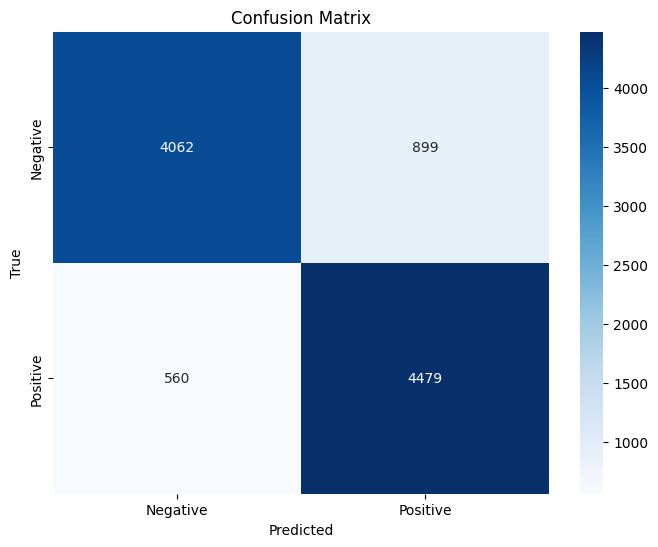

In [70]:
# prompt: GENERA MATRIZ DE CONFUNSION DE MANERA VISUAL

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (Your existing code) ...

# Assuming y_test and y_pred_binary are defined from your model's prediction
cm = confusion_matrix(y_test, y_pred_binary)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

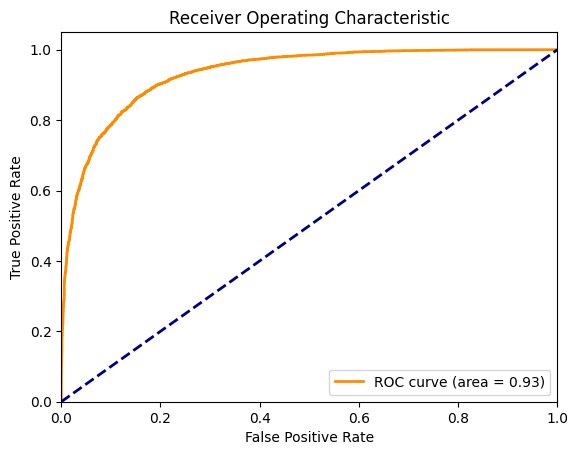

In [67]:
# prompt: genera Curvas ROC Para evaluar la capacidad del modelo para diferenciar entre clases positivas y negativas.

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ... (Your existing code) ...


# Assuming y_test contains the true labels and y_predlr contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_predlr)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()